In [3]:
import sys
import pandas as pd
import os
res=pd.DataFrame(index=['Mapping genes','Mapping GFs','TP homo','FP homo','FN homo','Precision homo','Recall homo','F1-score homo'])

directory_path = os.getcwd()
tool='PanDelos'
identities = ['50']
coverages = ['0','50','80']
frags = ['0.5','0.6','0.7','0.8','0.9'] 

for identity in identities:
    print(identity)
    for coverage in coverages:
        print(coverage)

        res=pd.DataFrame(index=['PanProva genes',
                                'PanDelos genes',
                                'Mapping genes',
                                'PanProva homo',
                                'PanDelos homo',
                                'Mapping homo',
                                'F1-score mapping homo',
                                'PanProva GFs',
                                'PanDelos GFs',
                                'Mapping GFs'])

        for fragmentation in frags:
            print(fragmentation)
            imap = directory_path+'/PanProva_myco/mappings/perc_id_'+identity+'/qcov_'+coverage+'/pandelos_'+fragmentation+'_bbmapping.csv'
            ipanprova = directory_path+'/PanProva_myco/DBS_myco_10_leaf_genomes_fragments_'+fragmentation+'/survival_families'
            ipandelos = directory_path+'/myco/myco_'+fragmentation+'/'+tool+'/output/output.clus'

            print('reading mapping...')
            prgenes = set()
            degenes = set()

            pr2de = dict()
            de2pr = dict()

            # Read mapping file
            for line in open(imap,'r'):
                cc = line.strip().split(' ')
                de = cc[1]
                pr = cc[0]
                
                degenes.add(de) # all genes left in delos
                prgenes.add(pr) # all genes left in prova

                # create reciprocal dictionaries (delos to prova and back)
                if de not in de2pr:
                    de2pr[de] = pr
                if pr not in pr2de:
                    pr2de[pr] = de

            mapping=len(pr2de)
            print('Mappings:',mapping) 
            

            # Read all homologies (before blasting)
            #print('reading panprova homologies...')
            prgenes = set()
            prhomos = set()
            for line in open(ipanprova,'r'):
                cc = line.strip().split(' ')
                for i in range(1, len(cc)):
                    prgenes.add(cc[i])
                    for j in range(i+1, len(cc)):
                        prhomos.add( (cc[i],cc[j]) )
                        prhomos.add( (cc[j],cc[i]) )
            print('total involved pr genes', len(prgenes),';number of total homologies', len(prhomos))

            #print('reading pandelos homologies...')
            dehomos = set()
            degenes = set()
            for line in open(ipandelos,'r'):
                cc = line.strip().split(' ')
                for i in range(0, len(cc)):
                    degenes.add(cc[i])
                    for j in range(i+1, len(cc)):
                        dehomos.add( (cc[i],cc[j]) )
                        dehomos.add( (cc[j],cc[i]) )
            print('involved de genes', len(degenes), ';number of homologies', len(dehomos))

            # COnsidering only homologies retained after blasting (de2pr/pr2de) compute stats
            tp,tn,fp,fn = 0,0,0,0

            for c in dehomos:
                if (c[0] in de2pr) and (c[1] in de2pr): # if both genes were kept in delos

                    m = ( de2pr[c[0]], de2pr[c[1]] )
                    if m in prhomos: # and this couple exists in panrpova
                        tp += 1
                    else:
                        fp += 1

            for c in prhomos:
                if (c[0] in pr2de) and (c[1] in pr2de):# if both genes were kept in prova (meaning they have been mappend to some delos)
                    m = ( pr2de[c[0]], pr2de[c[1]] )
                    if m not in dehomos:
                        fn += 1

            #print('tp',tp,'fp',fp,'fn',fn)
            precision = tp/ ( tp +fp )
            recall = tp / (tp + fn)
            f1score = 2 * tp / ( (2*tp) + fp + fn )
            fdr = fp / (fp + tp)

            #print('precision',precision,'recall', recall,'f1score',f1score,'fdr',fdr)

            # Gene family analyses
            print('reading panprova GFs...')
            prGFs = dict()
            line_count_pr = 0
            option_1 = True
            for line in open(ipanprova,'r'):
                cc = line.strip().split(' ')
                if len(cc) > 1:
                    line_count_pr += 1
                    found_map = None
                    
                    # Opzione 1: Any gene maps
                    if option_1:
                        for i in range(1, len(cc)):
                            if cc[i] in pr2de: 
                                found_map = True
                                break
                    # Opzione 2: All genes map
                    else:
                        if all([c in pr2de for c in cc[1:]]):
                            found_map = True
                    
                    if found_map != None:
                        gene_name = str(cc[0].split('_')[2].rstrip(')'))
                        prGFs['family_'+gene_name] = set()
                        for i in range(1, len(cc)):
                            if str(cc[i].split(',')[1].rstrip(')')) == gene_name:
                                prGFs['family_'+gene_name].add(cc[i]) 
                            #elif cc[i] in pr2de: #insert found paralogues as singletons???
                            #    prGFs['family_'+str(cc[i].split(',')[1].rstrip(')'))] = set()
                            #    prGFs['family_'+str(cc[i].split(',')[1].rstrip(')'))].add(cc[i])

            #print('number of pr GFs',line_count,'of which', len(prGFs), 'map')

            #print('reading pandelos GFs...')
            deGFs = dict()
            line_count_de = 0

            for line in open(ipandelos,'r'):
                cc = line.strip().split(' ')
                line_count_de +=1
                found_map = None
                            
                # Opzione 1: Any gene maps
                if option_1:
                    for i in range(0, len(cc)):
                        if cc[i] in de2pr: 
                            found_map = i
                            break
                # Opzione 2: All genes map
                else:
                    if all([c in de2pr for c in cc]): 
                        found_map = 0

                if found_map != None:
                    pr_conversion = 'family_'+de2pr[cc[found_map]].split(',')[1].rstrip(')')
                    deGFs[pr_conversion] = set()
                    for i in range(0, len(cc)):
                        deGFs[pr_conversion].add(cc[i]) 
            #print('number of de GFs',line_count, 'of which', len(deGFs),'map')

            import pandas as pd
            df_pr = pd.DataFrame.from_dict({k:len(prGFs[k]) for k in prGFs.keys()}, orient='index')
            df_de = pd.DataFrame.from_dict({k:len(deGFs[k]) for k in deGFs.keys()}, orient='index')
            df_merge = pd.merge(df_pr, df_de,how='inner',left_index=True,right_index=True) 
            df_merge = df_merge.set_axis(['PanProva', 'PanDelos'], axis=1, inplace=False)
            #print('Mapping GFs:',len(df_merge))

            res = res.join(pd.DataFrame.from_dict({'PanProva genes':len(prgenes),
                                                   'PanDelos genes':len(degenes),
                                                   'Mapping genes':str(int(mapping)),
                                                   'PanProva homo': len(prhomos),
                                                   'PanDelos homo': len(dehomos),
                                                   'Mapping homo':int(tp)+int(fn),
                                                   'F1-score mapping homo':round(f1score,2),
                                                   'PanProva GFs':line_count_pr,
                                                   'PanDelos GFs':line_count_de,
                                                   'Mapping GFs': int(len(df_merge))},
                                                    orient='index',columns=[fragmentation]))

        res.to_csv('/home/claudia/Desktop/ADAIR/PanDelos-frags/myco/stats/delos_perc_id'+identity+'_qcov_'+coverage+'.csv')

50
0
0.5
reading mapping...
Mappings: 3090
total involved pr genes 3270 ;number of total homologies 20242
involved de genes 4433 ;number of homologies 23230
reading panprova GFs...
0.6
reading mapping...
Mappings: 3531
total involved pr genes 3740 ;number of total homologies 25928
involved de genes 5121 ;number of homologies 29368
reading panprova GFs...
0.7
reading mapping...
Mappings: 3974
total involved pr genes 4208 ;number of total homologies 32358
involved de genes 5815 ;number of homologies 36354
reading panprova GFs...
0.8
reading mapping...
Mappings: 4336
total involved pr genes 4606 ;number of total homologies 38088
involved de genes 6472 ;number of homologies 43382
reading panprova GFs...
0.9
reading mapping...
Mappings: 4547
total involved pr genes 4836 ;number of total homologies 41784
involved de genes 6980 ;number of homologies 48502
reading panprova GFs...
50
0.5
reading mapping...
Mappings: 2939
total involved pr genes 3270 ;number of total homologies 20242
involved de

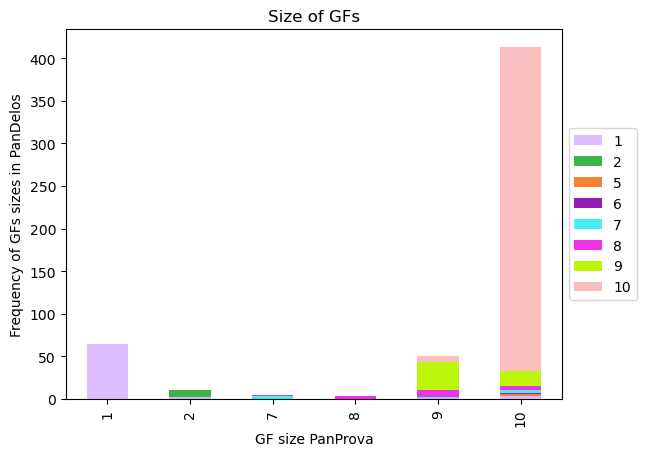

In [4]:
# take only GFs where pandelos > roary
#compare_mapping_genes_greater = compare_mapping_genes[compare_mapping_genes['Flag']=='>']
#compare_mapping_genes_greater['value']=1
import matplotlib.pyplot as plt
df_merge['value']=1
df_merge_stratify = df_merge.pivot_table(columns='PanDelos',index='PanProva',values='value',aggfunc='sum').fillna(0)
#plot it  
colors_10= ['#dcbeff', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6194b', '#9a6324','#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff']
colors_10 = [i for e,i in enumerate(colors_10) if e+1 in list(set(df_merge['PanDelos']))]
df_merge_stratify.plot(kind='bar',stacked=True,legend=True,
                                    color= colors_10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),labels=sorted(list(set(df_merge['PanDelos']))))
plt.ylabel('Frequency of GFs sizes in PanDelos')
plt.xlabel('GF size PanProva')
plt.title('Size of GFs')
plt.show()


In [5]:
from collections import Counter
Counter(df_merge['PanDelos'])

Counter({10: 388, 7: 8, 1: 71, 9: 50, 8: 18, 6: 1, 5: 2, 2: 9})

In [6]:
flag_df = []
for g in df_merge.index:
    pr=df_merge.loc[g,'PanProva']
    de=df_merge.loc[g,'PanDelos']

    if de>pr:
        flag='>'
    elif pr>de:
        flag='<'
    else:
        flag='='
    dict_row = {'GF_size_pandelos': de, 'GF_size_PanProva':pr,'Flag': flag}
    flag_df.append(dict_row)
flag_df = pd.DataFrame(flag_df)

Counter({'=': 491, '<': 46, '>': 10})


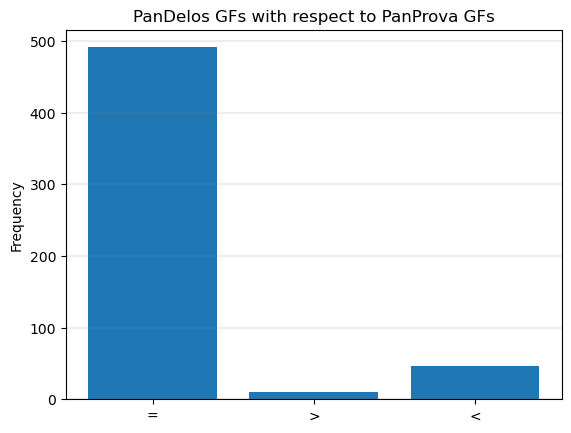

In [7]:
from collections import Counter
c=Counter(flag_df['Flag'])
print(c)
plt.ylabel('Frequency')
plt.title('PanDelos GFs with respect to PanProva GFs')
plt.bar(c.keys(),c.values()) 
plt.grid(True, axis='y', color = "grey", linewidth = "0.2")

# Now with ROARY


In [10]:
res=pd.DataFrame(index=['Mapping genes','Mapping GFs','TP homo','FP homo','FN homo','Precision homo','Recall homo','F1-score homo'])

tool="Roary"

for identity in identities:
    for coverage in coverages:
        res=pd.DataFrame(index=['PanProva genes',
                                'Roary genes',
                                'Mapping genes',
                                'PanProva homo',
                                'Roary homo',
                                'Mapping homo',
                                'F1-score mapping homo',
                                'PanProva GFs',
                                'Roary GFs',
                                'Mapping GFs'])

        for fragmentation in frags: 
 
            iroary = directory_path+'/myco/myco_'+fragmentation+'/'+tool+'/clustered_proteins'
            imap = directory_path+'/PanProva_myco/mappings/perc_id_'+identity+'/qcov_'+coverage+'/pandelos_'+fragmentation+'_bbmapping.csv'
            ipanprova = directory_path+'/PanProva_myco/DBS_myco_10_leaf_genomes_fragments_'+fragmentation+'/survival_families'

            print('reading mapping...')
            prgenes = set()
            rrgenes = set()

            pr2rr = dict()
            rr2pr = dict()

            for line in open(imap,'r'):
                cc = line.strip().split(' ')
                rr = cc[1]
                pr = cc[0]
                
                rrgenes.add(rr)
                prgenes.add(pr)

                if rr not in rr2pr:
                    rr2pr[rr] = pr
                if pr not in pr2rr:
                    pr2rr[pr] = rr

            mapping=len(rr2pr)

            print()
            print('reading panprova homologies...')
            prgenes = set()
            prhomos = set()
            for line in open(ipanprova,'r'):
                cc = line.strip().split(' ')
                for i in range(1, len(cc)):
                    prgenes.add(cc[i])
                    for j in range(i+1, len(cc)):
                        prhomos.add( (cc[i],cc[j]) )
                        prhomos.add( (cc[j],cc[i]) )
            print('involved pr genes', len(prgenes),';number of homologies', len(prhomos))

            print()
            print('reading roary homologies...')
            rrhomos = set()
            rrgenes = set()
            for line in open(iroary,'r'):
                cc = line.strip().split(':')[1].strip().split('\t')
                for i in range(0, len(cc)):
                    rrgenes.add(cc[i])
                    for j in range(i+1, len(cc)):
                        rrhomos.add( (cc[i],cc[j]) )
                        rrhomos.add( (cc[j],cc[i]) )
            print('involved rr genes', len(rrgenes), ';number of homologies', len(rrhomos))

            print()
            print('getting statistics...')
            tp,tn,fp,fn = 0,0,0,0

            for c in rrhomos:
                if (c[0] in rr2pr) and (c[1] in rr2pr):
                    m = ( rr2pr[c[0]], rr2pr[c[1]] )
                    if m in prhomos:
                        tp += 1
                    else:
                        fp += 1

            for c in prhomos:
                if (c[0] in pr2rr) and (c[1] in pr2rr):
                    m = ( pr2rr[c[0]], pr2rr[c[1]] )
                    if m not in rrhomos:
                        fn += 1

            print('tp',tp,'fp',fp,'fn',fn)
            if tp+fp == 0:
                precision = 0
            else:
                precision = tp/ ( tp + fp )
            
            if tp+fn == 0:
                recall = 0
            else:
                recall = tp / (tp + fn)
            
            if recall == 0 and precision == 0 :
                f1score = 0
            else:
                f1score = 2 * tp / ( (2*tp) + fp + fn )
            
            #fdr = fp / (fp + tp)

            print('precision',precision,'recall', recall,'f1score',f1score,'fdr',fdr)
            print('reading panprova GFs...')
            option_1=True
            prGFs_r = dict()
            line_count_pr = 0
            for line in open(ipanprova,'r'):
                cc = line.strip().split(' ')
                if len(cc) > 1:
                    line_count_pr += 1
                    found_map = None
                    
                    # Opzione 1: Any gene maps
                    if option_1:
                        for i in range(1, len(cc)):
                            if cc[i] in pr2rr: # if among all genes there is a known conversion
                                found_map = True
                                break
                            
                    # Opzione 2: All genes map
                    else:
                        if all([c in pr2rr for c in cc[1:]]): 
                            found_map = True
                        
                    
                    if found_map != None:
                        gene_name = str(cc[0].split('_')[2].rstrip(')'))
                        prGFs_r['family_'+gene_name] = set()
                        for i in range(1, len(cc)):
                            if str(cc[i].split(',')[1].rstrip(')')) == gene_name:
                                prGFs_r['family_'+gene_name].add(cc[i]) 
                            #elif cc[i] in pr2rr: #insert found paralogues as singletons???
                            #    prGFs['family_'+str(cc[i].split(',')[1].rstrip(')'))] = set()
                            #    prGFs['family_'+str(cc[i].split(',')[1].rstrip(')'))].add(cc[i])

            #print('number of pr GFs',line_count_pr,'of which', len(prGFs_r), 'map')

            print('reading roary GFs...')
            rrGFs = dict()
            line_count_rr = 0
            for line in open(iroary,'r'):
                line_count_rr +=1
                cc =  line.strip().split(':')[1].strip().split('\t')
                found_map = None
                
                # Opzione 1: any gene maps
                if option_1:
                    for i in range(0, len(cc)):
                        if cc[i] in rr2pr: # if among all genes there is a known conversion
                            found_map = i 
                            break
                # Opzione 2: All genes map
                else:
                    if all([c in rr2pr for c in cc]): 
                        found_map = 0
                        
                if found_map != None:
                    pr_conversion = 'family_'+rr2pr[cc[found_map]].split(',')[1].rstrip(')')
                    rrGFs[pr_conversion] = set()
                    for i in range(0, len(cc)):
                        rrGFs[pr_conversion].add(cc[i]) 
            #print('number of de GFs',line_count, 'of which', len(rrGFs),'map')

            import pandas as pd
            df_pr_r = pd.DataFrame.from_dict({k:len(prGFs_r[k]) for k in prGFs_r.keys()}, orient='index')
            df_rr = pd.DataFrame.from_dict({k:len(rrGFs[k]) for k in rrGFs.keys()}, orient='index')
            df_merge_r = pd.merge(df_pr_r, df_rr,how='inner',left_index=True,right_index=True) 
            df_merge_r = df_merge_r.set_axis(['PanProva', 'Roary'], axis=1, inplace=False)
            #print('Mapping GFs:',len(df_merge))
 

            res = res.join(pd.DataFrame.from_dict({'PanProva genes':len(prgenes),
                                                   'Roary genes':len(rrgenes),
                                                   'Mapping genes':str(int(mapping)),
                                                   'PanProva homo': len(prhomos),
                                                   'Roary homo': len(rrhomos),
                                                   'Mapping homo':int(tp)+int(fn),
                                                   'F1-score mapping homo':round(f1score,2),
                                                   'PanProva GFs':line_count_pr,
                                                   'Roary GFs':line_count_rr,
                                                   'Mapping GFs': int(len(df_merge_r))},
                                                    orient='index',columns=[fragmentation]))

        res.to_csv('/home/claudia/Desktop/ADAIR/PanDelos-frags/myco/stats/roary_perc_id'+identity+'_qcov_'+coverage+'.csv')

reading mapping...

reading panprova homologies...
involved pr genes 3270 ;number of homologies 20242

reading roary homologies...
involved rr genes 5275 ;number of homologies 7604

getting statistics...
tp 2592 fp 36 fn 11144
precision 0.9863013698630136 recall 0.18870122306348283 f1score 0.316792960156441 fdr 0.0008551068883610451
reading panprova GFs...
reading roary GFs...
reading mapping...

reading panprova homologies...
involved pr genes 3740 ;number of homologies 25928

reading roary homologies...
involved rr genes 6408 ;number of homologies 11248

getting statistics...
tp 3768 fp 88 fn 14738
precision 0.9771784232365145 recall 0.2036096401167189 f1score 0.33700026831231555 fdr 0.0008551068883610451
reading panprova GFs...
reading roary GFs...
reading mapping...

reading panprova homologies...
involved pr genes 4208 ;number of homologies 32358

reading roary homologies...
involved rr genes 7517 ;number of homologies 15118

getting statistics...
tp 4990 fp 132 fn 18972
precision

In [ ]:
import pandas as pd
df_pr_r = pd.DataFrame.from_dict({k:len(prGFs_r[k]) for k in prGFs_r.keys()}, orient='index')
df_rr = pd.DataFrame.from_dict({k:len(rrGFs[k]) for k in rrGFs.keys()}, orient='index')

In [ ]:
df_merge_r = pd.merge(df_pr_r, df_rr, left_index=True, right_index=True)
df_merge_r = df_merge_r.set_axis(['PanProva', 'Roary'], axis=1, inplace=False)

['#dcbeff', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe']


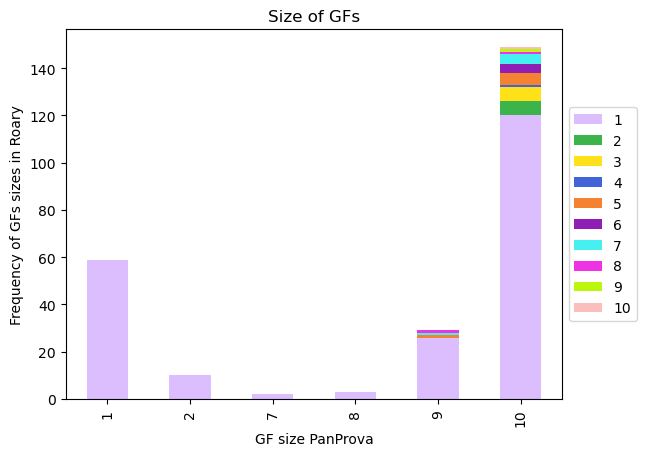

In [ ]:
# take only GFs where pandelos > roary
#compare_mapping_genes_greater = compare_mapping_genes[compare_mapping_genes['Flag']=='>']
#compare_mapping_genes_greater['value']=1
import matplotlib.pyplot as plt
df_merge_r['value']=1
df_merge_r_stratify = df_merge_r.pivot_table(columns='Roary',index='PanProva',values='value',aggfunc='sum').fillna(0)
#plot it 
colors_10= ['#dcbeff', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6194b', '#9a6324','#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080', '#ffffff']
colors_10 = [i for e,i in enumerate(colors_10) if e+1 in list(set(df_merge_r['Roary']))]
print(colors_10)
df_merge_r_stratify.plot(kind='bar',stacked=True,legend=True,
                                    color= colors_10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),labels=sorted(list(set(df_merge_r['Roary']))))

plt.ylabel('Frequency of GFs sizes in Roary')
plt.xlabel('GF size PanProva')
plt.title('Size of GFs')
plt.show()


Counter({'<': 192, '=': 60})


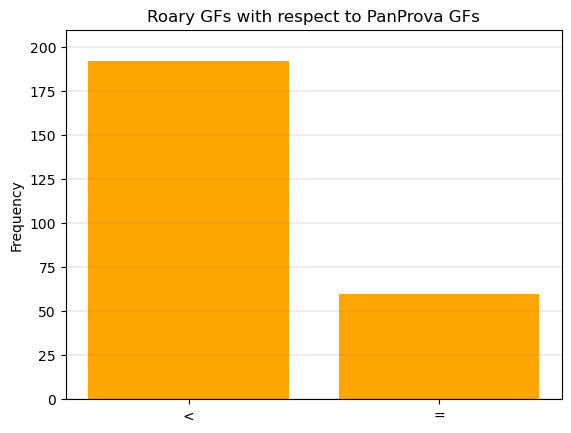

In [ ]:
flag_df_r = []
for g in df_merge_r.index:
    rr=df_merge_r.loc[g,'Roary']
    pr=df_merge_r.loc[g,'PanProva']

    if rr>pr:
        flag='>'
    elif pr>rr:
        flag='<'
    else:
        flag='='
    dict_row = {'GF_size_Roary': rr, 'GF_size_PanProva':pr,'Flag': flag}
    flag_df_r.append(dict_row)
flag_df_r = pd.DataFrame(flag_df_r)
c=Counter(flag_df_r['Flag'])
print(c)
plt.ylabel('Frequency')
plt.title('Roary GFs with respect to PanProva GFs')
plt.bar(c.keys(),c.values(),color='orange') 
plt.ylim(0, 210)
plt.grid(True, axis='y', color = "grey", linewidth = "0.2")

In [ ]:
mergeroni = pd.merge(df_merge_r,df_merge,left_index=True,right_index=True) #507

In [ ]:
mergeroni

,PanProva_x,Roary,value_x,PanProva_y,PanDelos,value_y
family_0,10,1,1,10,10,1
family_101,10,1,1,10,10,1
family_103,10,1,1,10,10,1
family_107,9,1,1,9,9,1
family_109,10,1,1,10,10,1
...,...,...,...,...,...,...
family_545,1,1,1,1,1,1
family_547,1,1,1,1,1,1
family_548,1,1,1,1,1,1
family_517,1,1,1,1,1,1


In [ ]:
mergeroni_flag = []
for g in mergeroni.index:
    rr=mergeroni.loc[g,'Roary']
    pr=mergeroni.loc[g,'PanProva_x']
    de=mergeroni.loc[g,'PanDelos']

    if rr>pr:
        flag_rr='>'
    elif pr>rr:
        flag_rr='<'
    else:
        flag_rr='='
        
        
    if de>pr:
        flag_de='>'
    elif pr>de:
        flag_de='<'
    else:
        flag_de='=' 
        
        
    dict_row = {'GF_size_PanDelos': de, 'GF_size_Roary': rr, 'GF_size_PanProva':pr,'Flag_Roary': flag_rr, 'Flag_PanDelos': flag_de}
    
    mergeroni_flag.append(dict_row)
mergeroni_flag = pd.DataFrame(mergeroni_flag)
  

In [ ]:
print(Counter(mergeroni_flag['Flag_PanDelos']))
print(Counter(mergeroni_flag['Flag_Roary']))

Counter({'=': 214, '<': 24, '>': 5})
Counter({'<': 192, '=': 51})


In [ ]:
list(Counter(mergeroni_flag['Flag_PanDelos']).keys())

['=', '>', '<']

([<matplotlib.axis.XTick at 0x7ff662c5c7d0>,
 [Text(0.55, 0, '='), Text(1.5, 0, '>'), Text(2.55, 0, '<')])

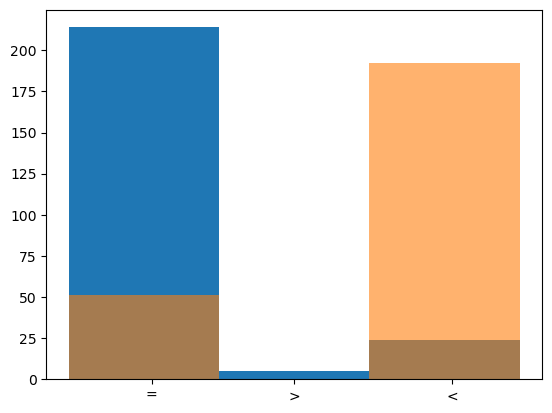

In [ ]:
plt.hist(mergeroni_flag['Flag_PanDelos'],bins = [0,1,2,3])
plt.hist(mergeroni_flag['Flag_Roary'],bins = [0,1,2,3],alpha=0.6)
plt.xticks([0.55,1.5,2.55], list(Counter(mergeroni_flag['Flag_PanDelos']).keys()))

In [ ]:
import numpy as np
df_merge=df_merge.loc[np.array(mergeroni.index)]
df_merge_r=df_merge_r.loc[np.array(mergeroni.index)] #rerun barplot-color after this to have only GFs 3-wayammped

In [11]:
identity = '50'#['0','50']
coverages = ['0','50','80']
tools = ['delos','roary']

for tool in tools: 
        c = 0 

        for coverage in coverages:
                if c==0:
                        tab_tmp =  pd.read_csv('/home/claudia/Desktop/ADAIR/PanDelos-frags/myco/stats/'+tool+'_perc_id'+identity+'_qcov_'+coverage+'.csv', index_col=0)
                else:
                        tab_tmp = pd.merge(tab_tmp,pd.read_csv('/home/claudia/Desktop/ADAIR/PanDelos-frags/myco/stats/'+tool+'_perc_id'+identity+'_qcov_'+coverage+'.csv',index_col=0),left_index=True,right_index=True,suffixes=(None,'_'+str(coverage)))

                c +=1
        
        tab_tmp.to_csv('/home/claudia/Desktop/ADAIR/PanDelos-frags/myco/stats/'+tool+'_all.csv')



In [12]:
tab_tmp

,0.5,0.6,0.7,0.8,0.9,0.5_50,0.6_50,0.7_50,0.8_50,0.9_50,0.5_80,0.6_80,0.7_80,0.8_80,0.9_80
PanProva genes,3270.00,3740.00,4208.00,4606.00,4836.00,3270.00,3740.00,4208.00,4606.00,4836.00,3270.00,3740.00,4208.00,4606.00,4836.00
Roary genes,5275.00,6408.00,7517.00,8644.00,9745.00,5275.00,6408.00,7517.00,8644.00,9745.00,5275.00,6408.00,7517.00,8644.00,9745.00
Mapping genes,2604.00,3058.00,3532.00,3960.00,4313.00,1097.00,1357.00,1641.00,1921.00,2170.00,511.00,655.00,800.00,958.00,1073.00
PanProva homo,20242.00,25928.00,32358.00,38088.00,41784.00,20242.00,25928.00,32358.00,38088.00,41784.00,20242.00,25928.00,32358.00,38088.00,41784.00
Roary homo,7604.00,11248.00,15118.00,20082.00,25670.00,7604.00,11248.00,15118.00,20082.00,25670.00,7604.00,11248.00,15118.00,20082.00,25670.00
Mapping homo,13736.00,18506.00,23962.00,29520.00,34638.00,3590.00,5132.00,7484.00,10128.00,12734.00,1466.00,2166.00,3098.00,4388.00,5378.00
F1-score mapping homo,0.32,0.34,0.34,0.37,0.37,0.47,0.46,0.48,0.47,0.48,0.54,0.53,0.55,0.55,0.53
PanProva GFs,560.00,569.00,583.00,599.00,604.00,560.00,569.00,583.00,599.00,604.00,560.00,569.00,583.00,599.00,604.00
Roary GFs,3412.00,3906.00,4417.00,4872.00,5290.00,3412.00,3906.00,4417.00,4872.00,5290.00,3412.00,3906.00,4417.00,4872.00,5290.00
Mapping GFs,518.00,526.00,545.00,559.00,566.00,353.00,376.00,402.00,421.00,432.00,185.00,208.00,230.00,241.00,252.00
